## Autoencoder model 

In [142]:
#Keras model
from keras.engine import InputLayer
from keras.layers import Conv2D, UpSampling2D
from keras.models import Sequential

#Pre-Trained model
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions

#image format handling
from skimage import io, color, transform
import matplotlib.pyplot as plt
from PIL import Image as Img

from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf

#stuff
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


%load_ext autoreload
%autoreload 2

np.random.seed(400)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [187]:
def pre_processImage(image):
    image = transform.resize(image, (224, 224, 3), mode='constant')
    lab = color.rgb2lab(image)
    gray = color.rgb2gray(image)
    gray = gray[:, :, np.newaxis]
    return gray, lab

In [191]:
image =  io.imread('sample.jpg')
gray, lab = pre_processImage(image)
print(gray.shape)
print(lab.shape)
print(gray)

_ = plt(gray, cmap='gray')

(224, 224, 1)
(224, 224, 3)
[[[0.90238395]
  [0.86594267]
  [0.72719988]
  ...
  [0.07405725]
  [0.07405725]
  [0.07405725]]

 [[0.79819184]
  [0.71623068]
  [0.56972044]
  ...
  [0.07405725]
  [0.07405725]
  [0.07405725]]

 [[0.60616599]
  [0.46701688]
  [0.34510537]
  ...
  [0.07405725]
  [0.07405725]
  [0.07405725]]

 ...

 [[0.03473373]
  [0.03502152]
  [0.03529922]
  ...
  [0.03490795]
  [0.03082426]
  [0.02983213]]

 [[0.03473373]
  [0.03502152]
  [0.03529922]
  ...
  [0.0350266 ]
  [0.03091378]
  [0.02994072]]

 [[0.03473373]
  [0.03502152]
  [0.03529922]
  ...
  [0.03547344]
  [0.03125091]
  [0.03034966]]]


TypeError: 'module' object is not callable

In [161]:
def normalize_data(image):
    #standardising image data
    std_image = image/255.
    
    #Normalizing image data
    #do by row as this is row and non transformed images
    #For each row i.e 1x3072
    image_mean = np.mean(std_image)
    image_std = np.std(std_image)
    
    #mean shape is 1 
    image_mean = np.tile(image_mean, std_image.shape)
    image_std = np.tile(image_std, std_image.shape)
    norm_image = (std_image - image_mean) / image_std 
    
    return norm_image

In [162]:
def encoder_cnn():
    """
    Encoder module to get lower level features from the given single channel/luminance 
    input image.
    
    Args: 
    image -- luminance channel of image (224,224)
    
    return: 
    model -- Encoding (28,28,256) - low level features of dim H/8,W/8,D i.e (224/8) 
    """
    model = Sequential(name='encoder')
    model.add(InputLayer(input_shape=(None, None, 1))) # Any gray-scale
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    return model

In [163]:
image =  io.imread('sample.jpg')
lab, gray = pre_processImage(image)
print(gray.shape)
encoder = encoder_cnn()
val = encoder.predict(gray)
print(val)
#encoder.summary()

(224, 224, 3)


ValueError: Error when checking input: expected input_24 to have 4 dimensions, but got array with shape (224, 224, 3)

In [78]:
def decoder(fusionLayer_depth):
    model = Sequential(name='decoder')
    model.add(InputLayer(input_shape=(None, None, fusionLayer_depth)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2))) #increase resolution by factor 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2))) #increase resolution by factor 2
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
    model.add(UpSampling2D((2, 2)))
    return model

In [79]:
decoder = decoder(1257)
#decoder.summary()

In [80]:
def inceptionNet(inp):
#     x = image.img_to_array(inp)
#     x = np.expand_dims(x, axis=0)
#     x = preprocess_input(x)
    model = InceptionResNetV2(weights='imagenet')
    return model

In [81]:
inceptionNet = inceptionNet('sample.jpeg')
#inceptionNet.summary()

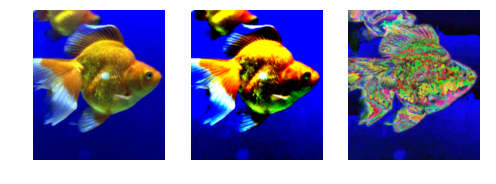

In [169]:
image =  io.imread('sample.jpg')
_ = plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
_ = plt.subplot(1,3,1)
_ = plt.axis('off')
_ = plt.imshow(image, interpolation = 'gaussian')
norm_image = normalize_data(image)
_ = plt.subplot(1,3,2)
_ = plt.axis('off')
_ = plt.imshow(norm_image, interpolation = 'gaussian')
_ = plt.subplot(1,3,3)
_ = plt.axis('off')
img = norm_image * 255.
img = Img.fromarray(img.astype("uint8"))
_ = plt.imshow(img,interpolation='bicubic')

In [125]:
ImageDataGenerator.flow_from_dataframe(directory=r'one_pic', target_size=(224, 224), color_mode='gray', interpolation='nearest')


TypeError: unbound method flow_from_dataframe() must be called with ImageDataGenerator instance as first argument (got nothing instead)

In [ ]:
tf.image.per_image_standardization(image)
